In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Section 2.2 Buvoli SDC for advection 1D

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0$$
$$\frac{\partial u}{\partial t} = - c \frac{\partial u}{\partial x}$$
c - velocity
$$u(x, 0) = e^{-x^2}; u(-\infty, t) = u(\infty, t) = 0$$
solution: $$u(x, t) = e^{-(x - ct)^2}$$

#### Explicit Euler-based SDC

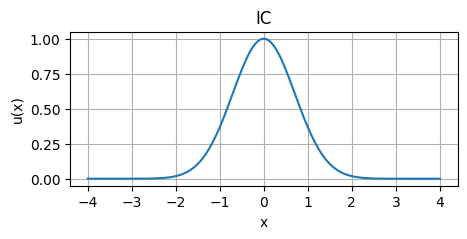

In [11]:
L = 201
c = 0.2 # velocity
h = 0.1 # timestep

def gauss(x):
    return np.exp(-x**2)

x = np.linspace(-4,4,L)
hx = x[1] - x[0]

fig = plt.figure(figsize=(5, 2))
ax = plt.axes()
plt.plot(x, gauss(x))
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('IC')
plt.grid()
plt.show()

#### analytical solution

CFL = 0.7821723252011532


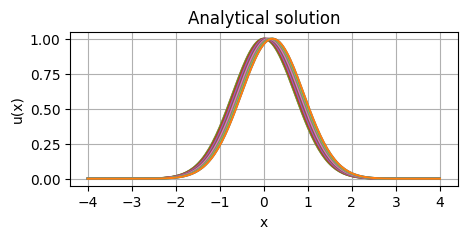

In [12]:
# timestep substeps: quadrature points Chebyshev-Gauß
N = 10
taui, weights = np.polynomial.chebyshev.chebgauss(N)

# stretch to [0, 1] timestep and add 0 and 1
taui = taui[::-1] / 2 + 0.5
taui = np.pad(taui, 1, "constant")
taui[-1] = 1. 
ht = taui[1:] - taui[:-1]

print("CFL =", c*max(ht)/hx)

fig = plt.figure(figsize=(5, 2))
ax = plt.axes()
analytical = np.zeros((N+2, L))
for i in range(0, N+2):
    analytical[i] = np.exp(-(x - c * taui[i])*(x - c * taui[i]))
    plt.plot(x, analytical[i], label=np.round(taui[i], decimals=2))
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Analytical solution')
plt.grid()
plt.show()

#### 2ord upwind

sweep no 0 taui 1 max error 3.1888878493369077e-06
sweep no 0 taui 2 max error 9.72722914944768e-05
sweep no 0 taui 3 max error 0.00043495280776273404
sweep no 0 taui 4 max error 0.0010747884011780284
sweep no 0 taui 5 max error 0.001962084927252694
sweep no 0 taui 6 max error 0.0029424129216580885
sweep no 0 taui 7 max error 0.0038376838869348395
sweep no 0 taui 8 max error 0.004485633848805182
sweep no 0 taui 9 max error 0.004826407428272672
sweep no 0 taui 10 max error 0.004920366124213427
sweep no 0 taui 11 max error 0.004922519607839737


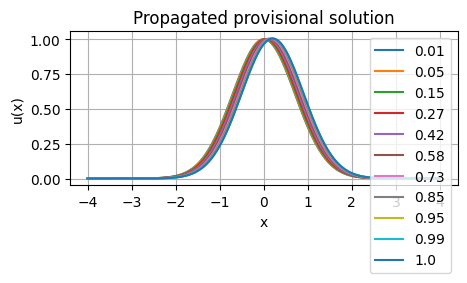

In [13]:
solutions = np.zeros((N+2, L))
rhs = np.zeros((N+2, L))

solutions[0] = gauss(x)

# using 2ord upwind
def F(u):
    u2 = (3*u[2:] - 4*u[1:-1] + u[:-2]) / (2 * hx)
    u2 = np.insert(u2, 0, [0., 0.])
    return (-c * u2)
        
fig = plt.figure(figsize=(5, 2))
ax = plt.axes()
# propagate forward Euler through time substeps
for i in range(1, N+2): # 1 to N-1
    rhs[i-1] = F(solutions[i-1])
    solutions[i] = solutions[i-1] + ht[i-1] * rhs[i-1]
    plt.plot(x, solutions[i], label=np.round(taui[i], decimals=2))
    print("sweep no 0 taui", i, "max error", np.max(np.abs(solutions[i] - analytical[i])))
    
rhs[i] = F(solutions[i])
    
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Propagated provisional solution')
plt.legend()
plt.grid()
plt.show()

easy example for (9), aka one correction sweep


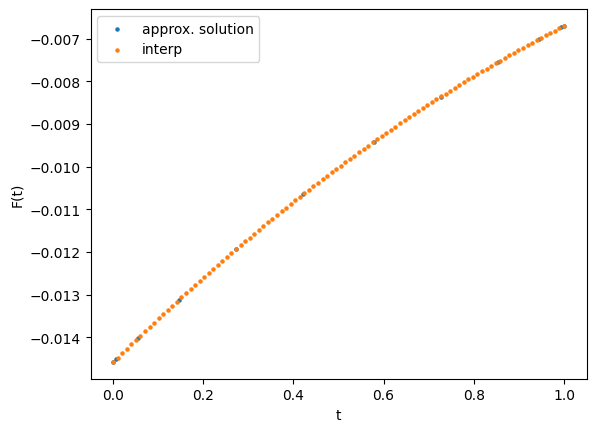

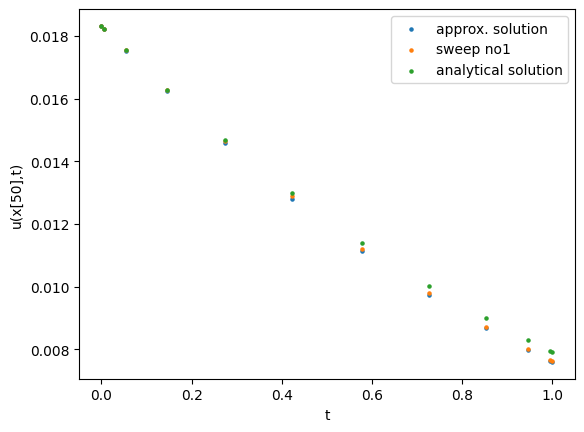

In [14]:
print("easy example for (9), aka one correction sweep")
x_slice=50

# fit and plot
Order=10
series = np.polynomial.chebyshev.Chebyshev(np.ones((Order)), domain=[-1,1], window=[0,1])
series = series.fit(taui, rhs[:,x_slice], Order)

plt.scatter(taui, rhs[:,x_slice], s=5, label="approx. solution")
plt.scatter(series.linspace()[0], series.linspace()[1], s=5, label="interp")
plt.xlabel("t")
plt.ylabel("F(t)")
plt.legend()
plt.show()

# integrate and calculate I(phi_k)
integseries = series.integ(m=1, lbnd=0.)
zerotonode = integseries(taui)
nodetonode = zerotonode[1:] - zerotonode[:-1]
# perform a sweep on x[x_slice]
plt.scatter(taui, solutions[:,x_slice], s=5, label="approx. solution")
x_slicesolution = solutions[:,x_slice].copy()

Ek = np.zeros_like(x)
for i in range(1, N+2):
    # Rˆ(hτi+1, hτi, φk) = φk(hτi) − φk(hτi+1) + Ii+1(φk) i
    I = nodetonode[i-1] # integral fraction in (i;i+1)
    #print("--- i =", i)
    #print("I =",I)
    R = solutions[i-1, x_slice] - solutions[i, x_slice] + I
    #print("delta phi", solutions[i-1, x_slice] - solutions[i, x_slice])
    #print("R =",R)
    # G(s, E (s)) = F (s, φk (s) + E (s)) − F (s, φk (s))
    G = F(solutions[i-1] + Ek)[x_slice] - F(solutions[i-1])[x_slice] # explicit
    #print("G =",G)
    Ek[x_slice] += ht[i-1] * G + R
    #print("Ek =",Ek[x_slice])
    x_slicesolution[i] += Ek[x_slice]
plt.scatter(taui, x_slicesolution, s=5, label="sweep no1")
plt.scatter(taui, analytical[:,x_slice], s=5, label="analytical solution")
plt.xlabel("t")
plt.ylabel("u(x[50],t)")
plt.legend()
plt.show()

#### N time substeps, M sweeps, L x-points

In [15]:
M = 5
# init chebychev series
# Order=10
# series = np.polynomial.chebyshev.Chebyshev(np.ones((Order)), domain=[-1,1], window=[0,1])
nodetonode = np.zeros((N+1, L))

Ek = np.zeros_like(x) # ?
for k in range(M): # sweeps
    
    for i in range(0, N+2): # time substeps rhs
        rhs[i] = F(solutions[i])
        
    for x_slice in range(0, L): # rhs integration
        series = series.fit(taui, rhs[:,x_slice], Order)
        integseries = series.integ(m=1, lbnd=0.)
        zerotonode = integseries(taui)
        nodetonode[:, x_slice] = zerotonode[1:] - zerotonode[:-1]
        
    for i in range(1, N+2): # time substeps
        I = nodetonode[i-1] # integral fraction in (i;i+1)
        R = solutions[i-1] - solutions[i] + I
        # G(s, E (s)) = F (s, φk (s) + E (s)) − F (s, φk (s))
        G = F(solutions[i-1] + Ek) - F(solutions[i-1]) # explicit
        Ek += ht[i-1] * G + R
        solutions[i] -= Ek # I have to change the sign otherwise doesn't seem to work :<
    print("sweep no", k+1, "taui", i, "max error", np.max(np.abs(solutions[i] - analytical[i])))

sweep no 1 taui 11 max error 0.004924072367162191
sweep no 2 taui 11 max error 0.004831721804955835
sweep no 3 taui 11 max error 0.0743433855920269
sweep no 4 taui 11 max error 73.7334939243144
sweep no 5 taui 11 max error 74951.23247529786


#### 6th ord rhs

sweep no 0 taui 11 max error 0.004922549947806054


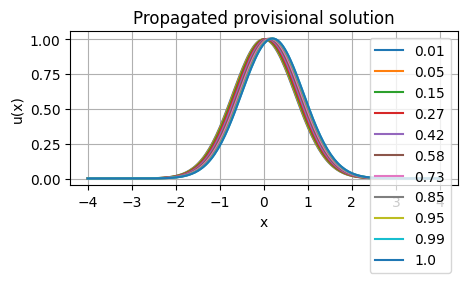

In [16]:
# using 6th order central difference
def F(u):
    u6 = (1/60 * u[6:] - 3/20 * u[5:-1] + 3/4 * u[4:-2] -3/4 * u[2:-4] +
            3/20 * u[1:-5] -1/60 * u[:-6]) / hx
    u6 = np.pad(u6, 3, "constant")
    return (-c * u6)

solutions = np.zeros((N+2, L))
rhs = np.zeros((N+2, L))

solutions[0] = gauss(x)
        
fig = plt.figure(figsize=(5, 2))
ax = plt.axes()
# propagate forward Euler through time substeps
for i in range(1, N+2): # 1 to N-1
    rhs[i-1] = F(solutions[i-1])
    solutions[i] = solutions[i-1] + ht[i-1] * rhs[i-1]
    plt.plot(x, solutions[i], label=np.round(taui[i], decimals=2))
print("sweep no 0 taui", i, "max error", np.max(np.abs(solutions[i] - analytical[i])))
    
rhs[i] = F(solutions[i])
    
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Propagated provisional solution')
plt.legend()
plt.grid()
plt.show()

In [17]:
M = 5
# init chebychev series
# Order=10
# series = np.polynomial.chebyshev.Chebyshev(np.ones((Order)), domain=[-1,1], window=[0,1])
nodetonode = np.zeros((N+1, L))

Ek = np.zeros_like(x) # ?
for k in range(M): # sweeps
    
    for i in range(0, N+2): # time substeps rhs
        rhs[i] = F(solutions[i])
        
    for x_slice in range(0, L): # rhs integration
        series = series.fit(taui, rhs[:,x_slice], Order)
        integseries = series.integ(m=1, lbnd=0.)
        zerotonode = integseries(taui)
        nodetonode[:, x_slice] = zerotonode[1:] - zerotonode[:-1]
        
    for i in range(1, N+2): # time substeps
        I = nodetonode[i-1] # integral fraction in (i;i+1)
        R = solutions[i-1] - solutions[i] + I
        # G(s, E (s)) = F (s, φk (s) + E (s)) − F (s, φk (s))
        G = F(solutions[i-1] + Ek) - F(solutions[i-1]) # explicit
        Ek += ht[i-1] * G + R
        solutions[i] -= Ek # I have to change the sign otherwise doesn't seem to work :<
    print("sweep no", k+1, "taui", i, "max error", np.max(np.abs(solutions[i] - analytical[i])))

sweep no 1 taui 11 max error 0.004924073241574067
sweep no 2 taui 11 max error 0.0048324008366502635
sweep no 3 taui 11 max error 0.0048029057272227504
sweep no 4 taui 11 max error 0.0050867372751961515
sweep no 5 taui 11 max error 0.0060068582170205165


### analytical rhs

sweep no 0 taui 11 max error 0.004857506467211503


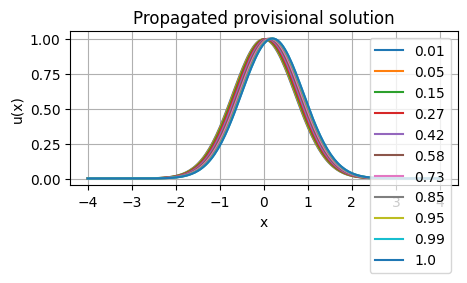

In [18]:
# using analytical solution -c du/dx = c exp-(x-ct)^2 2(x-ct)
def F_an(x, t):
    return (c * np.exp(-(x - c * t)**2) * 2*(x - c * t))

solutions = np.zeros((N+2, L))
rhs = np.zeros((N+2, L))

solutions[0] = gauss(x)
        
fig = plt.figure(figsize=(5, 2))
ax = plt.axes()
# propagate forward Euler through time substeps
for i in range(1, N+2): # 1 to N-1
    rhs[i-1] = F_an(x, taui[i-1])
    solutions[i] = solutions[i-1] + ht[i-1] * rhs[i-1]
    plt.plot(x, solutions[i], label=np.round(taui[i], decimals=2))
print("sweep no 0 taui", i, "max error", np.max(np.abs(solutions[i] - analytical[i])))
    
rhs[i] = F(solutions[i])
    
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Propagated provisional solution')
plt.legend()
plt.grid()
plt.show()

In [19]:
M = 5
# init chebychev series
# Order=10
# series = np.polynomial.chebyshev.Chebyshev(np.ones((Order)), domain=[-1,1], window=[0,1])
nodetonode = np.zeros((N+1, L))

Ek = np.zeros_like(x) # ?
for k in range(M): # sweeps
    
    for i in range(0, N+2): # time substeps rhs
        rhs[i] = F_an(x, taui[i])
        
    for x_slice in range(0, L): # rhs integration
        series = series.fit(taui, rhs[:,x_slice], Order)
        integseries = series.integ(m=1, lbnd=0.)
        zerotonode = integseries(taui)
        nodetonode[:, x_slice] = zerotonode[1:] - zerotonode[:-1]
        
    for i in range(1, N+2): # time substeps
        I = nodetonode[i-1] # integral fraction in (i;i+1)
        R = solutions[i-1] - solutions[i] + I
        # G(s, E (s)) = F (s, φk (s) + E (s)) − F (s, φk (s))
        G = F(solutions[i-1] + Ek) - F_an(x, taui[i-1]) # explicit
        Ek += ht[i-1] * G + R
        solutions[i] -= Ek # I have to change the sign otherwise doesn't seem to work :<
    print("sweep no", k+1, "taui", i, "max error", np.max(np.abs(solutions[i] - analytical[i])))

sweep no 1 taui 11 max error 0.004859513003877436
sweep no 2 taui 11 max error 0.0047695331134318675
sweep no 3 taui 11 max error 0.004754414769076676
sweep no 4 taui 11 max error 0.005052041771388738
sweep no 5 taui 11 max error 0.006000752547057009


#### for t=1.0 when 2ord upwind
0.004922519607839737 no sweeping  
0.004924072367162191 #1  
0.004831721804955835 #2  
0.0743433855920269 #3  
73.7334939243144 #4  
74951.23247529786 #5  

#### for t=1.0 when 6ord central
0.004922549947806054 no sweeping  
0.004924073241574067 #1  
0.0048324008366502635 #2  
0.0048029057272227504 #3  
0.0050867372751961515 #4  
0.0060068582170205165 #5  

#### for t=1.0 when analytical F(u)
0.004857506467211503 no sweeping  
0.004860649991573207 #1  
0.0047655633831926725 #2  
0.00474043354008713 #3  
0.005032521432373094 #4  
0.005966350864435976 #5  